<a href="https://colab.research.google.com/github/alexandre-pinon/zoidberg-2.0/blob/main/zoidberg_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Zoidberg 2.0

**Given some X-ray images, use machine learning to help doctors detecting pneumonia.**

## Notebook Config

In [ ]:
DATASET_DIR = "/content/zoidberg-2.0/chest_Xray_binary"
SEED = 2
IMG_SIZE = 224, 224
BATCH_SIZE = 32

In [ ]:
import os
import pathlib
import random

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Load data

In [ ]:
!git clone -b colab-data "https://github.com/alexandre-pinon/zoidberg-2.0.git"

Cloning into 'zoidberg-2.0'...
remote: Enumerating objects: 5907, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 5907 (delta 0), reused 5 (delta 0), pack-reused 5902
Receiving objects: 100% (5907/5907), 1.13 GiB | 32.12 MiB/s, done.
Resolving deltas: 100% (13/13), done.
Checking out files: 100% (11712/11712), done.


## Inspect data

In [ ]:
# Walk through 10_food_classes directory and list number of files
for dirpath, dirnames, filenames in os.walk(DATASET_DIR):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in '/content/zoidberg-2.0/chest_Xray_binary'.
There are 2 directories and 0 images in '/content/zoidberg-2.0/chest_Xray_binary/val'.
There are 0 directories and 8 images in '/content/zoidberg-2.0/chest_Xray_binary/val/pneumonia'.
There are 0 directories and 8 images in '/content/zoidberg-2.0/chest_Xray_binary/val/normal'.
There are 2 directories and 0 images in '/content/zoidberg-2.0/chest_Xray_binary/test'.
There are 0 directories and 390 images in '/content/zoidberg-2.0/chest_Xray_binary/test/pneumonia'.
There are 0 directories and 234 images in '/content/zoidberg-2.0/chest_Xray_binary/test/normal'.
There are 2 directories and 0 images in '/content/zoidberg-2.0/chest_Xray_binary/train'.
There are 0 directories and 3875 images in '/content/zoidberg-2.0/chest_Xray_binary/train/pneumonia'.
There are 0 directories and 1341 images in '/content/zoidberg-2.0/chest_Xray_binary/train/normal'.


In [ ]:
train_dir = f"{DATASET_DIR}/train/"
val_dir = f"{DATASET_DIR}/val/"
test_dir = f"{DATASET_DIR}/test/"

In [ ]:
# Get the class names for our multi-class dataset
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['normal' 'pneumonia']


In [ ]:
def view_random_images(target_dir, class_names):
  n_images = 10
  fig, ax = plt.subplots(2, 5, figsize=(24, 8))

  # Read in the image and plot it using matplotlib
  for i in range(n_images):
    target_class = random.choice(class_names)
    target_folder = target_dir + target_class

    # Get a random image path
    random_image = random.sample(os.listdir(target_folder), 1)[0]

    index = (0, i) if i < 5 else (1, i - 5)
    img = mpimg.imread(f'{target_folder}/{random_image}')
    ax[index].imshow(img, cmap='bone')
    ax[index].set_title(target_class)
    ax[index].set_frame_on(False)
    ax[index].set_xticks([])
    ax[index].set_yticks([])
    ax[index].set_xlabel(f"{img.shape}")

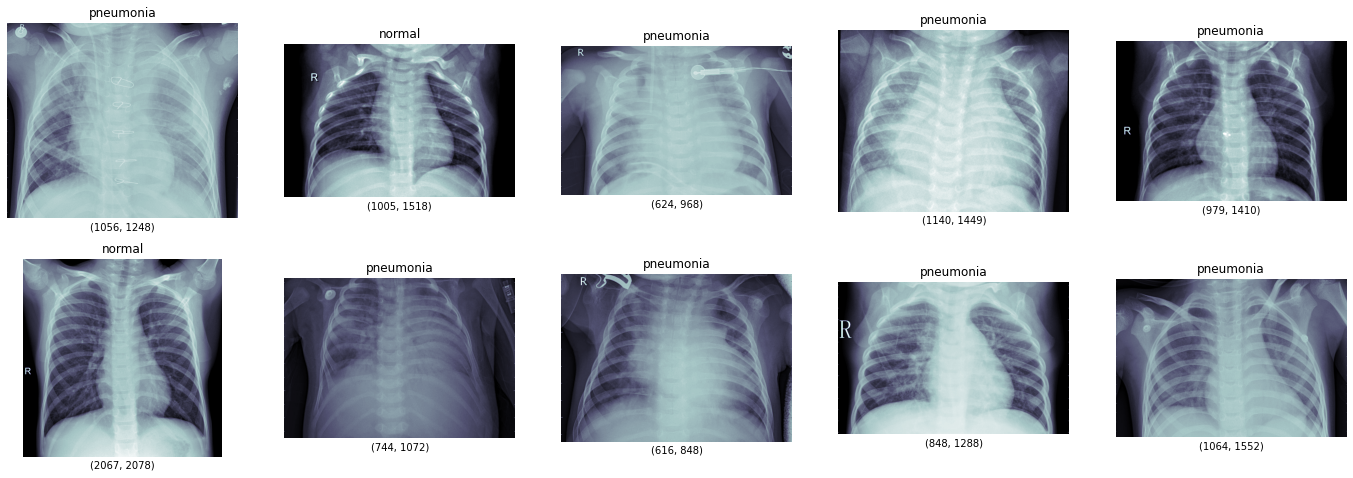

In [ ]:
# View a random image from the training dataset
img = view_random_images(target_dir=train_dir,
                         class_names=class_names)

## Preprocess data

In [ ]:
# Create train and test data generators and rescale the data 
train_datagen = ImageDataGenerator(rescale=1/255., validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [ ]:
# Turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size=IMG_SIZE,
                                               class_mode='binary',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=SEED,
                                               subset='training')

val_data = train_datagen.flow_from_directory(directory=train_dir,
                                           target_size=IMG_SIZE,
                                           class_mode='binary',
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,
                                           seed=SEED,
                                           subset='validation')

test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             target_size=IMG_SIZE,
                                             class_mode='binary',
                                             batch_size=BATCH_SIZE,
                                             shuffle=True,
                                             seed=SEED)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Create baseline model

In [ ]:
# Set random seed
tf.random.set_seed(SEED)

# Create the model
model_1 = Sequential([
  Flatten(input_shape=(*IMG_SIZE, 3)),
  Dense(4, activation='relu'),
  Dense(1, activation='relu'),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_1.compile(loss='binary_crossentropy', # binary since we are working with 2 classes (0 & 1)
                optimizer=Adam(),
                metrics='accuracy')


# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        validation_data=val_data) # fraction of the training data to be used as validation data

Epoch 1/5
131/131 [==============================] - 56s 422ms/step - loss: 0.6794 - accuracy: 0.7400 - val_loss: 0.6658 - val_accuracy: 0.7430
Epoch 2/5
131/131 [==============================] - 55s 418ms/step - loss: 0.6544 - accuracy: 0.7429 - val_loss: 0.6435 - val_accuracy: 0.7430
Epoch 3/5
131/131 [==============================] - 55s 418ms/step - loss: 0.6341 - accuracy: 0.7429 - val_loss: 0.6252 - val_accuracy: 0.7430
Epoch 4/5
131/131 [==============================] - 55s 420ms/step - loss: 0.6183 - accuracy: 0.7429 - val_loss: 0.6114 - val_accuracy: 0.7430
Epoch 5/5
131/131 [==============================] - 55s 422ms/step - loss: 0.6059 - accuracy: 0.7429 - val_loss: 0.6008 - val_accuracy: 0.7430


In [ ]:
model_1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 150528)            0         
                                                                 
 dense_21 (Dense)            (None, 4)                 602116    
                                                                 
 dense_22 (Dense)            (None, 1)                 5         
                                                                 
 dense_23 (Dense)            (None, 1)                 2         
                                                                 
Total params: 602,123
Trainable params: 602,123
Non-trainable params: 0
_________________________________________________________________


## Evaluate model

In [ ]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  fig, ax = plt.subplots(1, 2, figsize=(15, 5))

  # Plot loss
  ax[0].plot(epochs, loss, label='training_loss', c='r')
  ax[0].plot(epochs, val_loss, label='val_loss', c='orange')
  ax[0].set_title('Loss')
  ax[0].set_xlabel('Epochs')
  ax[0].legend()

  # Plot accuracy
  ax[1].plot(epochs, accuracy, label='training_accuracy', c='g')
  ax[1].plot(epochs, val_accuracy, label='val_accuracy', c='lightgreen')
  ax[1].set_title('Accuracy')
  ax[1].set_xlabel('Epochs')
  ax[1].legend()

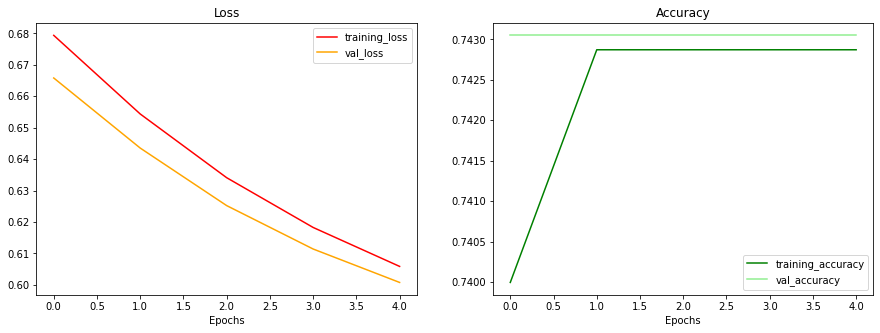

In [ ]:
plot_loss_curves(history_1)

In [ ]:
def evaluate_model(model, test_data):
  loss, acc = model.evaluate(test_data, verbose=False)
  print(f'Model loss {loss:.1f}')
  print(f'Model accuracy {acc:.1%}')

In [ ]:
evaluate_model(model_1, test_data)

Model loss 0.7
Model accuracy 62.5%


## Adjust the model parameters

In [ ]:
# Set random seed
tf.random.set_seed(SEED)

# Create the model
model_2 = Sequential([
  Flatten(input_shape=(*IMG_SIZE, 3)),
  Dense(100, activation='relu'),
  Dense(100, activation='relu'),
  Dense(100, activation='relu'),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_2.compile(loss='binary_crossentropy', # binary since we are working with 2 classes (0 & 1)
                optimizer=Adam(),
                metrics='accuracy')


# Fit the model
history_2 = model_2.fit(train_data,
                        epochs=5,
                        validation_data=val_data) # fraction of the training data to be used as validation data

Epoch 1/5
131/131 [==============================] - 56s 426ms/step - loss: 1.9145 - accuracy: 0.8088 - val_loss: 0.3562 - val_accuracy: 0.8754
Epoch 2/5
131/131 [==============================] - 54s 417ms/step - loss: 0.2811 - accuracy: 0.9058 - val_loss: 0.1864 - val_accuracy: 0.9348
Epoch 3/5
131/131 [==============================] - 55s 419ms/step - loss: 0.3014 - accuracy: 0.9104 - val_loss: 0.2078 - val_accuracy: 0.9271
Epoch 4/5
131/131 [==============================] - 55s 418ms/step - loss: 0.1824 - accuracy: 0.9384 - val_loss: 0.2621 - val_accuracy: 0.9003
Epoch 5/5
131/131 [==============================] - 55s 420ms/step - loss: 0.1318 - accuracy: 0.9521 - val_loss: 0.1645 - val_accuracy: 0.9358


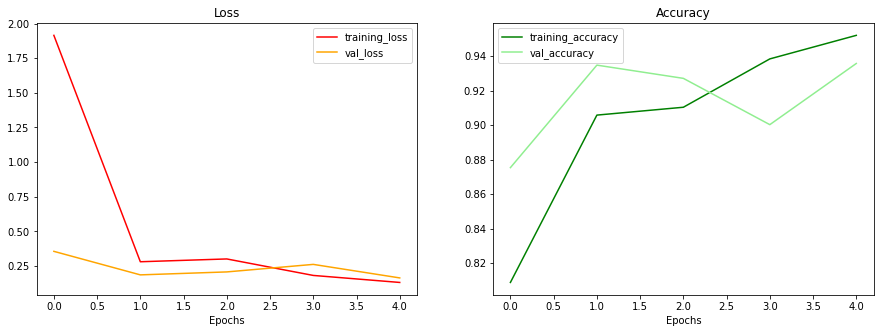

In [ ]:
plot_loss_curves(history_2)

In [ ]:
evaluate_model(model_2, test_data)

Model loss 0.7
Model accuracy 77.9%


## Making a prediction

In [ ]:
def make_val_predictions(model, class_names):
  # Import the target images and preprocess them
  plot_datagen = ImageDataGenerator(rescale=1/255.)
  plot_data = plot_datagen.flow_from_directory(directory=val_dir,
                                                target_size=IMG_SIZE,
                                                class_mode='binary',
                                                batch_size=BATCH_SIZE,
                                                shuffle=True,
                                                seed=SEED)
  # Make predictions
  preds = model.predict(plot_data).flatten()

  # Get predictions labels & percentages
  percentages = []
  preds_labels = []
  true_labels = class_names[plot_data.labels]

  for pred in preds:
    percentages.append(pred if pred >= 0.5 else 1 - pred)
    preds_labels.append(class_names[int(tf.round(pred))])

  n_images = len(preds)
  n_rows = n_cols = (n_images // 4)
  fig, axes = plt.subplots(n_rows,
                           n_cols,
                           figsize=(4 * n_cols, 3 * n_rows),
                           gridspec_kw={'wspace': 0, 'hspace': .6})
  axes = np.ravel(axes)

  for i, ax in enumerate(axes):
    if i == n_images:
      break

    img = mpimg.imread(plot_data.filepaths[i])
    color = 'green' if preds_labels[i] == true_labels[i] else 'red'

    ax.imshow(img, cmap='bone')
    ax.set_title(f"Pred: {preds_labels[i]} {percentages[i]:.1%}\n(True: {true_labels[i]})", c=color)
    ax.set_frame_on(False)
    ax.set_xticks([])
    ax.set_yticks([])

Found 16 images belonging to 2 classes.


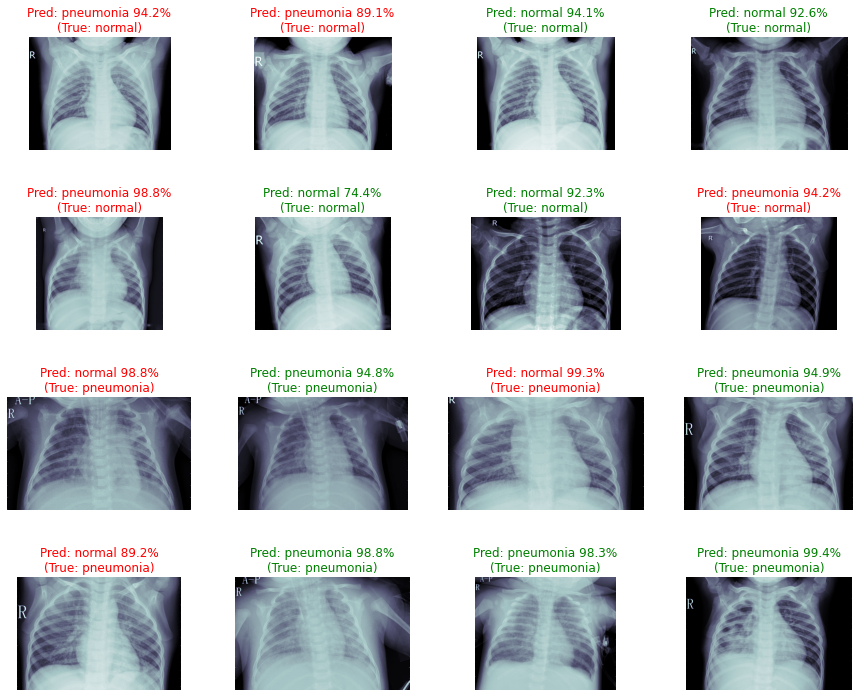

In [ ]:
make_val_predictions(model_2, class_names)

Found 16 images belonging to 2 classes.


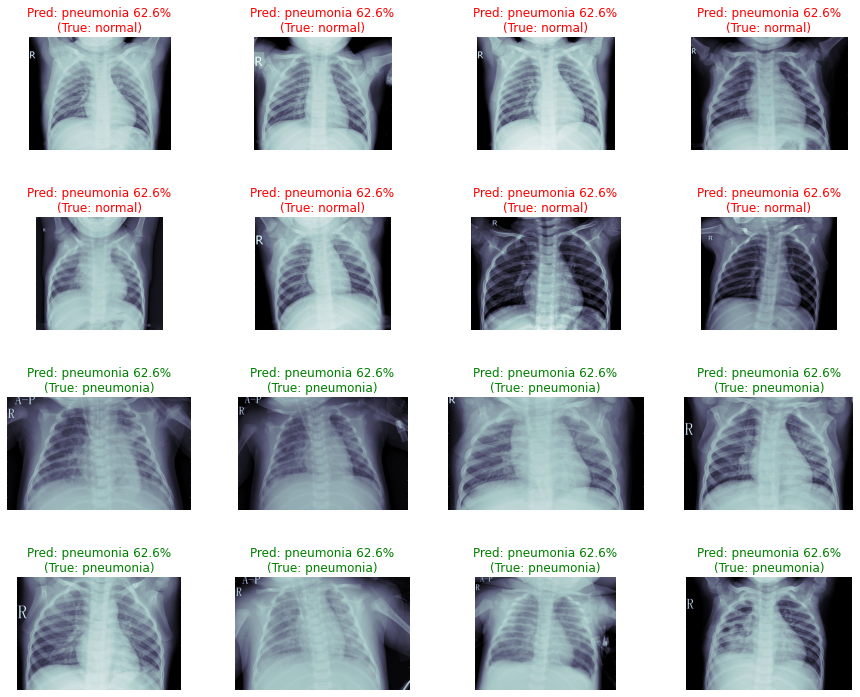

In [ ]:
make_val_predictions(model_1, class_names)

# CNN